In [1]:
# Fangjun Hu

# Preamble
import numpy as np
import math
import scipy
import random
import matplotlib.pyplot as plt
import scipy.linalg as la

from scipy.integrate import ode
from scipy.integrate import odeint
from scipy.linalg import expm, logm, sinm, cosm, svd
from scipy.optimize import minimize, fsolve, root # minimization

from numpy.linalg import matrix_rank
from sklearn import svm
from sklearn import linear_model
from copy import deepcopy

# Import qutip
from qutip import *
from qutip.expect import expect_rho_vec

import time

# Font
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)


In [2]:
params = {'axes.labelsize': '16',
    'axes.titlesize':'16',
    'xtick.labelsize':'20',
    'ytick.labelsize':'20',
    'lines.linewidth' : 1,
    'legend.fontsize': '14',
    'xtick.major.size': 6.,
    'ytick.major.size': 6.,
    }
plt.rcParams.update(params) 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#2ca02c","#8c564b", "#bcbd22", "#d62728",  
                                                    "#9467bd","#e377c2", "#7f7f7f", "#17becf", "#ff7f0e"])


In [3]:
params = {'axes.labelsize': '50',
    'axes.titlesize':'50',
    'xtick.labelsize':'50',
    'ytick.labelsize':'50',
    'lines.linewidth' : 4,
    'legend.fontsize': '40',
    'xtick.major.size': 40.,
    'ytick.major.size': 40.,
    'xtick.minor.size': 20.,
    'ytick.minor.size': 20.,
    }
plt.rcParams.update(params) 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#2ca02c","#8c564b", "#bcbd22", "#d62728",  
                                                    "#9467bd","#e377c2", "#7f7f7f", "#17becf", "#ff7f0e"])

In [4]:
# extra minimization
from sklearn import linear_model
# from skopt.utils import use_named_args
# from skopt.space import Real as spaceReal
# from skopt import gp_minimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import math
import h5py


In [5]:
def coerce(data):
    """Naively round to the nearest 4PAM symbol."""
    data[np.where(data>=2.0)]  =  3.0
    data[np.where(np.logical_and(data>=0.0, data<2.0))]  =  1.0
    data[np.where(np.logical_and(data>=-2.0, data<0.0))]  = -1.0
    data[np.where(data<=-2.0)] = -3.0
    return data

def Tikhonov_Regularization(X, y, lmd):
    w = np.linalg.solve((X.T @ X + lmd * np.identity(np.shape(X)[1])), X.T @ y)
    return w

def RMSE(w, X, y):
    (m, n) = np.shape(y)
    return np.sqrt((1/(m*n))*np.linalg.norm(y-X@w)**2)

# 1. Define Operators

In [6]:
def Classical_Entropy(eig_list):
    Entropy = 0
    for i in range(len(eig_list)): 
        if eig_list[i] !=0: 
            Entropy = Entropy - eig_list[i] * np.log(eig_list[i])/np.log(2)
    return Entropy


# Pauli Matrices 

σ_x = np.array([[0,   1], [1 ,  0]]) 
σ_y = np.array([[0, -1j], [1j,  0]]) 
σ_z = np.array([[1,   0], [0 , -1]])
I_2 = np.identity(2, dtype=int)

g = np.array([[0, 0], [0, 1]])
e = np.array([[1, 0], [0, 0]])

ψg = basis(2, 0)
ρg = ψg*ψg.dag()

ψe = basis(2, 1)
ρe = ψe*ψe.dag()


In [7]:
N_system  = 2
N_ancilla = 1
N_qubits  = N_system + N_ancilla

X_op = []  # Defined on all qubits
for i in range(N_qubits):
    X = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            X = tensor(X, sigmax())
        else: 
            X = tensor(X, qeye(2))
    X = X.ptrace(range(1, N_qubits + 1))
    X_op.append(X)

Z_op = []  # Defined on all qubits
for i in range(N_qubits):
    Z = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            Z = tensor(Z, sigmaz())
        else: 
            Z = tensor(Z, qeye(2))
    Z = Z.ptrace(range(1, N_qubits + 1))
    Z_op.append(Z)
    
C_op = []  # Defined on all qubits
for i in range(N_qubits):
    C = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            C = tensor(C, create(2))
        else: 
            C = tensor(C, qeye(2))
    C = C.ptrace(range(1, N_qubits + 1))
    C_op.append(C)
    
D_op = []  # Defined on all qubits
for i in range(N_qubits):
    D = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            D = tensor(D, destroy(2))
        else: 
            D = tensor(D, qeye(2))
    D = D.ptrace(range(1, N_qubits + 1))
    D_op.append(D)

len(X_op), len(Z_op), len(C_op), len(D_op)


(3, 3, 3, 3)

In [9]:
G_op = []  # Defined on all qubits
for i in range(N_qubits):
    G = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            G = tensor(G, (1+sigmaz())/2)
        else: 
            G = tensor(G, qeye(2))
    G = G.ptrace(range(1, N_qubits + 1))
    G_op.append(G)
    
E_op = []  # Defined on all qubits
for i in range(N_qubits):
    E = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            E = tensor(E, (1-sigmaz())/2)
        else: 
            E = tensor(E, qeye(2))
    E = E.ptrace(range(1, N_qubits + 1))
    E_op.append(E)


In [11]:
X_op[2], G_op[2], E_op[2]

(Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
 Qobj data =
 [[0. 1. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 1. 0.]],
 Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
 Qobj data =
 [[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]],
 Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]])

In [11]:
rseed = 17462 # seed for generator so get repeateable CE string
rs = np.random.RandomState(seed = rseed) # random number generator

hx0_vec = 1.0 + 1.0*rs.randn(N_qubits)
# hx1_vec = 0.5 + 0.0*rs.randn(N_qubits)
# hz0_vec = 1.0 + 0.3*rs.randn(N_qubits)
hz1_vec = 1.0 + 1.0*rs.randn(N_qubits)

J_graph = np.zeros((N_qubits, N_qubits))

# bi-partie network
# for i in range(N_qubits): 
#     for j in range(N_qubits): 
#         if i < N_system and j >= N_system: 
#             J_graph[i, j] = 1

# Complete graph
for i in range(N_qubits): 
    for j in range(N_qubits): 
        if i < j: J_graph[i, j] = 1
            
# Path graph
# for i in range(N_qubits-1): 
#     J_graph[i, i+1] = 1
# J_graph[0, N_qubits-1] = 1

# J_graph = np.array([[0, 0, 1, 1, 0, 0],
#                     [0, 0, 0, 0, 1, 1],
#                     [0, 0, 0, 1, 0, 0],
#                     [0, 0, 0, 0, 0, 0],
#                     [0, 0, 0, 0, 0, 1],
#                     [0, 0, 0, 0, 0, 0]])

# J_mat = np.random.rand(N_qubits, N_qubits)
J_mat = 0.0 + 1.0*rs.rand(N_qubits, N_qubits)
J_mat = J_mat * J_graph

γ_vec = 0.0 + 0.0*np.random.randn(N_qubits)

print(f'J_mat = \n{J_mat},\nhx0_vec = \n {hx0_vec},\nhz1_vec = \n {hz1_vec},\nγ_vec = \n {γ_vec}. ')


J_mat = 
[[0.         0.97658815 0.34120713]
 [0.         0.         0.29914534]
 [0.         0.         0.        ]],
hx0_vec = 
 [ 2.05874038 -0.22913328  0.71137219],
hz1_vec = 
 [0.75170655 1.19890224 0.90797956],
γ_vec = 
 [0. 0. 0.]. 


In [40]:
# Encode H0

H0 = 0
for i in range(N_qubits):
    H0 = H0 + hx0_vec[i] * X_op[i] * 1
# for i in range(N_qubits):
#     H0 = H0 + hz0_vec[i] * Z_op[i]
for i in range(N_qubits):
    for j in range(N_qubits):
        H0 = H0 + J_mat[i, j] * Z_op[i] * Z_op[j]
        
        
# Encode H1

H1 = 0
# for i in range(N_qubits):
#     H1 = H1 + hx1_vec[i] * X_op[i]
for i in range(N_qubits):
    H1 = H1 + hz1_vec[i] * Z_op[i] * 1

def Hamiltonian_Encoding(u): 
    return H0 + u*H1

def Ad(H, ρ):
    return H * ρ - ρ * H

def DT(ρ):
    S = 0
    for i in range(N_qubits):
        S = S + γ_vec[i] * (D_op[i]*ρ*C_op[i] - 0.5*C_op[i]*D_op[i]*ρ - 0.5*ρ*C_op[i]*D_op[i])
    return 1j * S


# 2. Conditional Dynamics, Ensemble Average, with Reset

In [41]:
# Input

L = 10
u_list = 2*np.random.rand(L) - 1
u_list.shape

(10,)

In [42]:
τ = 1

ψg = basis(2, 0)
ρg = ψg*ψg.dag()

ψe = basis(2, 1)
ρe = ψe*ψe.dag()

ρ0 = qeye(1)
for i in range(N_system): 
    ρ0 = tensor(ρ0, ρg)
ρ0 = ρ0.ptrace(range(1, N_system+1)) # Reduce dims

# ρ0 = Qobj(np.eye(2**N_system)/(2**N_system), dims = [[2]*N_system, [2]*N_system])

# State initialization
ρS  = ρ0
ρSE = ρS
for r in range(N_ancilla):
    ρSE = tensor(ρSE, ρg)

H = H0 + 1 * H1
U0  = (- 1j * τ * H).expm()
U0D = (+ 1j * τ * H).expm()
ρSE = U0 * ρSE * U0D

p = (G_op[2]*ρSE).tr()

random.choices([0, 1], [p, 1-p])

[0]

In [79]:
#### Choose different shots number nS_max here

# nS_max = 100
# nS_max = 1000
nS_max = 10000

sT = time.time()

ψg = basis(2, 0)
ρg = ψg*ψg.dag()

ψe = basis(2, 1)
ρe = ψe*ψe.dag()

ρ0 = qeye(1)
for i in range(N_system): 
    ρ0 = tensor(ρ0, ρg)
ρ0 = ρ0.ptrace(range(1, N_system+1)) # Reduce dims
    
Expect_Storage = []

for r in range(nS_max):
    
    # State initialization
    ρS  = ρ0
    ρSE = ρS
    for i in range(N_ancilla):
        ρSE = tensor(ρSE, ρg)
    
    Individual_Storage = []
    
    for t in range(L):

        H = H0 + u_list[t] * H1
        U0  = (- 1j * τ * H).expm()
        U0D = (+ 1j * τ * H).expm()
        ρSE = U0 * ρSE * U0D

        p = np.real((G_op[2]*ρSE).tr())
        b = random.choices([1, -1], [p, 1-p])[0]
        Individual_Storage.append(b)

        if b==1: 
            ρSE = (G_op[2] * ρSE * G_op[2]) / p
        else:
            ρSE = E_op[2] * ρSE * E_op[2] / (1 - p)
            ρSE = X_op[2] * ρSE * X_op[2]

    Expect_Storage.append(Individual_Storage)
    
Expect_Storage = np.array(Expect_Storage)
    
print(f'Total time = {np.round(time.time() - sT, 3)} s.')

Expect_Storage.shape


Total time = 192.484 s.


(10000, 10)

In [80]:
np.mean(Expect_Storage, axis=0)

array([0.4122, 0.1932, 0.3166, 0.21  , 0.2092, 0.4612, 0.2644, 0.3206,
       0.1978, 0.354 ])

In [127]:
#### Simulate infinite shots limit

sT = time.time()

ρ0 = qeye(1)
for i in range(N_system): 
    ρ0 = tensor(ρ0, ρg)
ρ0 = ρ0.ptrace(range(1, N_system+1)) # Reduce dims

# State initialization
ρS  = ρ0
ρSE = ρS
for i in range(N_ancilla):
    ρSE = tensor(ρSE, ρg)
    
Expect_Storage_Inf = []
    
for t in range(L):

    H = H0 + u_list[t] * H1
    U0  = (- 1j * τ * H).expm()
    U0D = (+ 1j * τ * H).expm()
    ρSE = U0 * ρSE * U0D
    
    Mean = np.real((Z_op[2]*ρSE).tr())
    Expect_Storage_Inf.append(Mean)

    ρS = ρSE.ptrace(range(N_system))
    ρSE = ρS
    for i in range(N_ancilla):
        ρSE = tensor(ρSE, ρg)

Expect_Storage_Inf = np.array(Expect_Storage_Inf)
    
print(f'Total time = {np.round(time.time() - sT, 3)} s.')

Expect_Storage_Inf.shape, Expect_Storage_Inf

Total time = 0.038 s.


((10,),
 array([0.40929925, 0.17463535, 0.32049796, 0.21081904, 0.20631339,
        0.4684348 , 0.26599132, 0.30925281, 0.197448  , 0.35420722]))

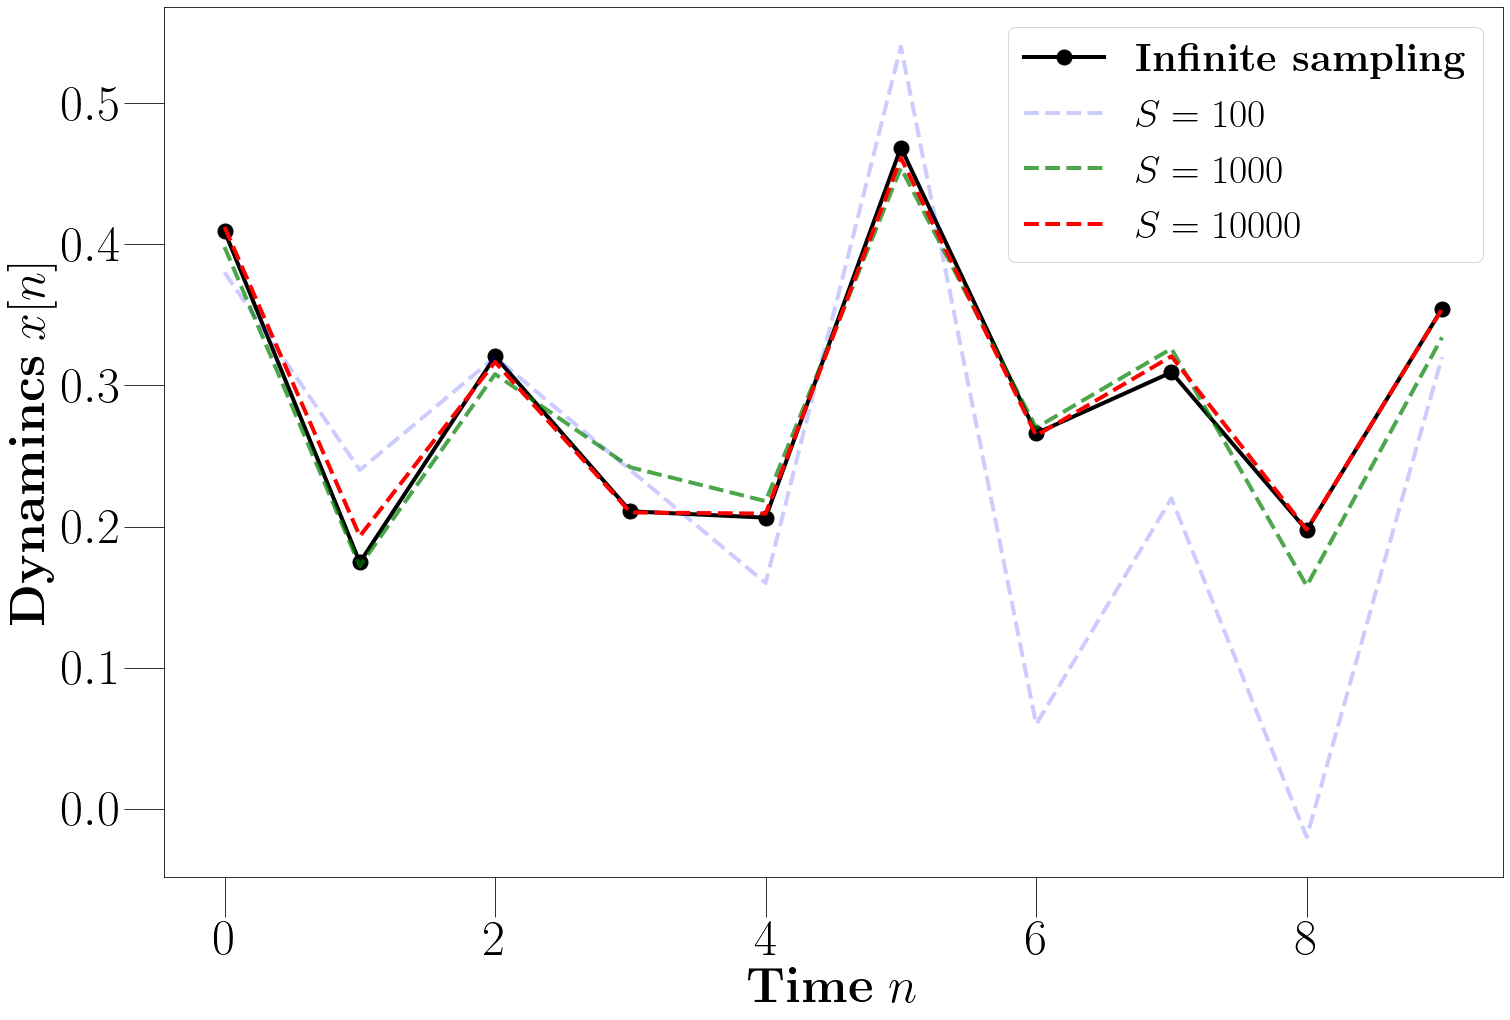

In [119]:
fig, axes = plt.subplots(1, 1, figsize=(24, 16))
ax = axes
ax.plot(range(L), Expect_Storage_Inf, 'k.-', label='\\textbf{Infinite sampling}', markersize = 30, alpha=1.0)
ax.plot(range(L), np.mean(Expect_Storage[:100, :],   axis=0), 'b--', label='$S = 100$',   alpha=0.2)
ax.plot(range(L), np.mean(Expect_Storage[:1000, :],  axis=0), 'g--', label='$S = 1000$',  alpha=0.7)
ax.plot(range(L), np.mean(Expect_Storage[:10000, :], axis=0), 'r--', label='$S = 10000$', alpha=1.0)
ax.set_ylabel('\\textbf{Dynamincs} $x[n]$')
ax.set_xlabel('\\textbf{Time} $n$')
ax.legend()

# 3. Conditional Dynamics, Ensemble Average, No Reset

In [132]:
#### Choose different shots number nS_max here

# nS_max = 100
# nS_max = 1000
nS_max = 10000

sT = time.time()

ψg = basis(2, 0)
ρg = ψg*ψg.dag()

ψe = basis(2, 1)
ρe = ψe*ψe.dag()

ρ0 = qeye(1)
for i in range(N_system): 
    ρ0 = tensor(ρ0, ρg)
ρ0 = ρ0.ptrace(range(1, N_system+1)) # Reduce dims
    
Expect_Storage_NoReset = []

for r in range(nS_max):
    
    # State initialization
    ρS  = ρ0
    ρSE = ρS
    for i in range(N_ancilla):
        ρSE = tensor(ρSE, ρg)
    
    Individual_Storage = []
    
    for t in range(L):

        H = H0 + u_list[t] * H1
        U0  = (- 1j * τ * H).expm()
        U0D = (+ 1j * τ * H).expm()
        ρSE = U0 * ρSE * U0D

        p = np.real((G_op[2]*ρSE).tr())
        b = random.choices([1, -1], [p, 1-p])[0]
        Individual_Storage.append(b)

        if b==1: 
            ρSE = (G_op[2] * ρSE * G_op[2]) / p
        else:
            ρSE = E_op[2] * ρSE * E_op[2] / (1 - p)

    Expect_Storage_NoReset.append(Individual_Storage)
    
Expect_Storage_NoReset = np.array(Expect_Storage_NoReset)
    
print(f'Total time = {np.round(time.time() - sT, 3)} s.')

Expect_Storage_NoReset.shape


Total time = 193.396 s.


(10000, 10)

In [133]:
Ih = Qobj([[1, 1], [1, 1]])

E = qeye(1)
for i in range(N_system): 
    E = tensor(E, Ih)
for i in range(N_ancilla): 
    E = tensor(E, qeye(2))
E = E.ptrace(range(1, N_qubits+1)) # Reduce dims

In [134]:
#### Simulate infinite shots limit

sT = time.time()

ρ0 = qeye(1)
for i in range(N_system): 
    ρ0 = tensor(ρ0, ρg)
ρ0 = ρ0.ptrace(range(1, N_system+1)) # Reduce dims

# State initialization
ρS  = ρ0
ρSE = ρS
for i in range(N_ancilla):
    ρSE = tensor(ρSE, ρg)
    
Expect_Storage_NoReset_Inf = []
    
for t in range(L):

    H = H0 + u_list[t] * H1
    U0  = (- 1j * τ * H).expm()
    U0D = (+ 1j * τ * H).expm()
    ρSE = U0 * ρSE * U0D
    
    Mean = np.real((Z_op[2]*ρSE).tr())
    Expect_Storage_NoReset_Inf.append(Mean)

    ρSE = Qobj(np.array(E) * np.array(ρSE), dims = [[2]*N_qubits, [2]*N_qubits])

Expect_Storage_NoReset_Inf = np.array(Expect_Storage_NoReset_Inf)
    
print(f'Total time = {np.round(time.time() - sT, 3)} s.')

Expect_Storage_NoReset_Inf.shape, Expect_Storage_NoReset_Inf

Total time = 0.036 s.


((10,),
 array([ 0.40929925,  0.06987984,  0.02722716,  0.01653768,  0.00194034,
         0.00448574,  0.00158749,  0.00773371, -0.00097218,  0.00145593]))

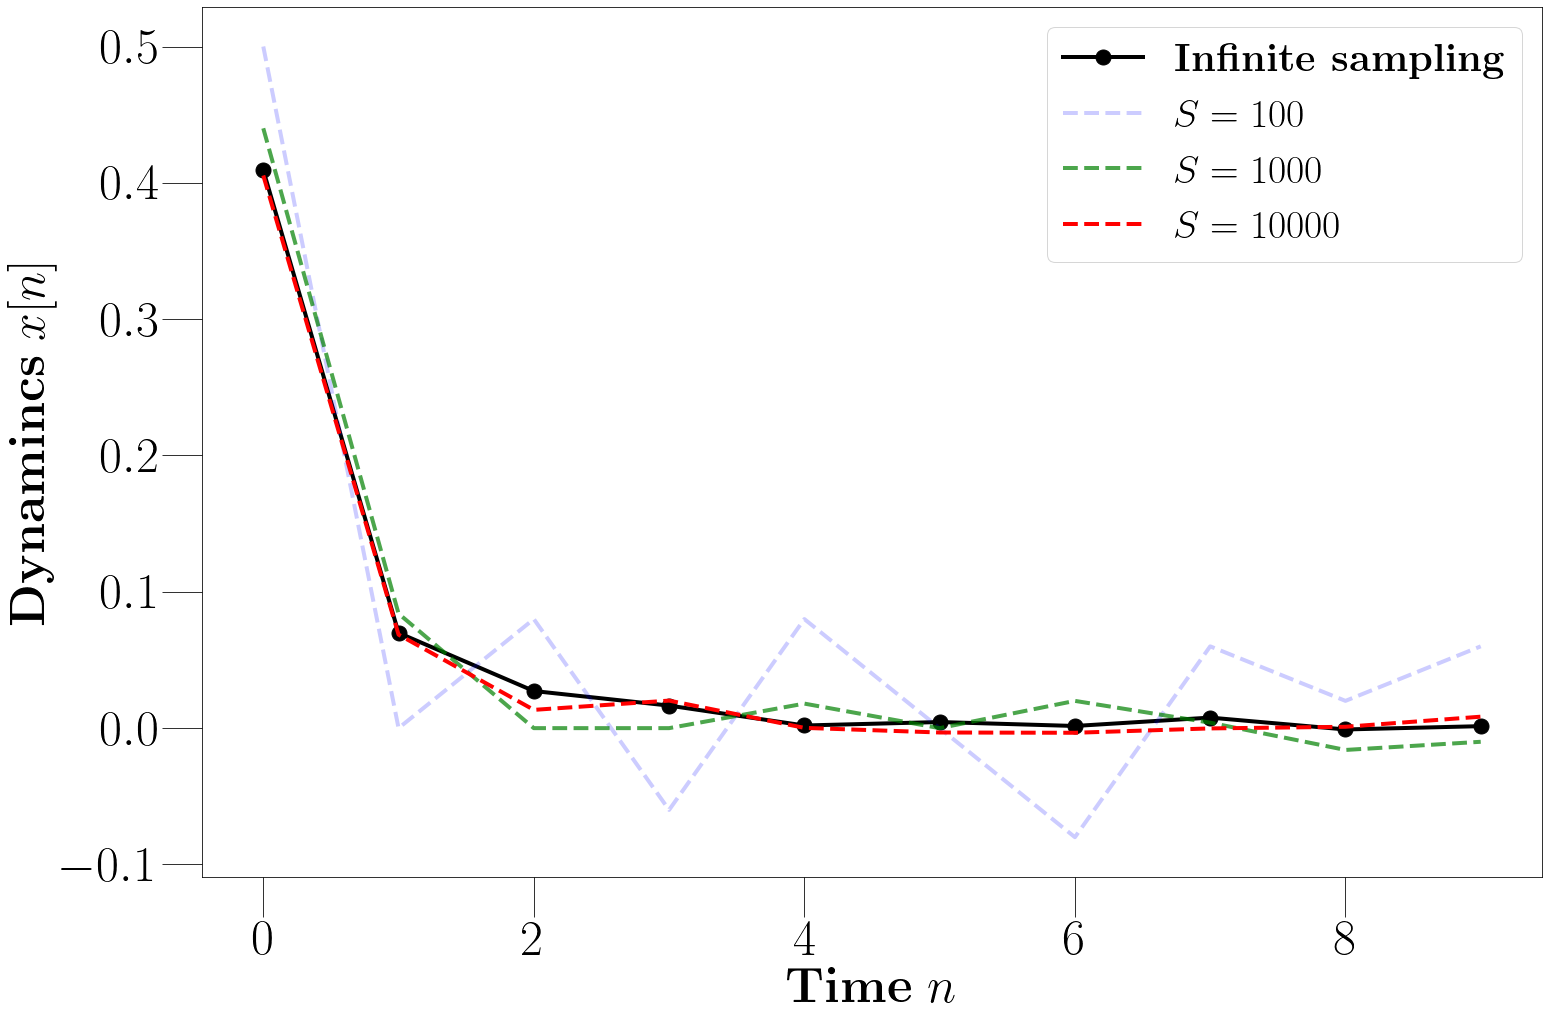

In [136]:
fig, axes = plt.subplots(1, 1, figsize=(24, 16))
ax = axes
ax.plot(range(L), Expect_Storage_NoReset_Inf, 'k.-', label='\\textbf{Infinite sampling}', markersize = 30, alpha=1.0)
ax.plot(range(L), np.mean(Expect_Storage_NoReset[:100, :],   axis=0), 'b--', label='$S = 100$',   alpha=0.2)
ax.plot(range(L), np.mean(Expect_Storage_NoReset[:1000, :],  axis=0), 'g--', label='$S = 1000$',  alpha=0.7)
ax.plot(range(L), np.mean(Expect_Storage_NoReset[:10000, :], axis=0), 'r--', label='$S = 10000$', alpha=1.0)
ax.set_ylabel('\\textbf{Dynamincs} $x[n]$')
ax.set_xlabel('\\textbf{Time} $n$')
ax.legend()